In [2]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from tbats import TBATS
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Question 3 Using Python, develop a systematic approach to forecast the number of people accessing Tumblr’s site each month. Make sure to compare and evaluate different models. What does your model imply for the valuation of Tumblr and Yahoo’s payment of $1.1 billion?

In [7]:
#reading in csv file containing tumblr MAU
df = pd.read_csv("Tumblr's Worldwide Montly Users.csv")
df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%y')
df.head()

,Date,Users,Quarter year
0,2010-04-01,19020118,2
1,2010-05-01,21096692,2
2,2010-06-01,22496896,2
3,2010-07-01,24571154,3
4,2010-08-01,27744680,3


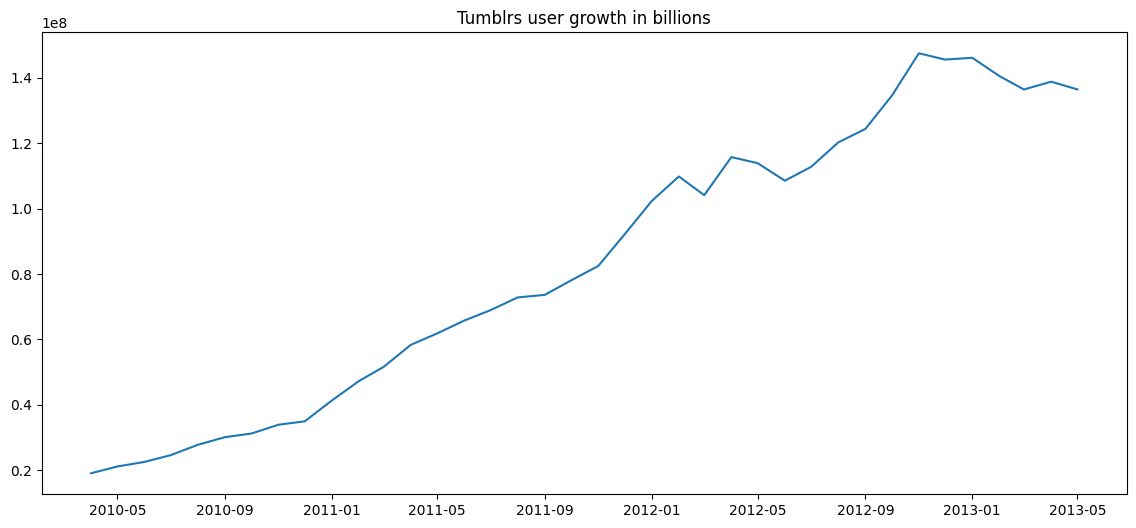

In [10]:
#plotting the number of users over time
fig, ax = plt.subplots(figsize=(14,6))
plt.plot(df['Date'],df['Users'])
plt.title('Tumblrs user growth in billions')
plt.show()

## 1. Time series decomposition

Next, we will decompose the time series into a trend, a seasonal component, and a residual ("error"). Note that we have to specify the period of the seasonal component ourselves. This usually requires some contextual knowledge, but yearly seasonality is the most common. Unfortunately, the basic decomposition packages do not allow us to add multiple seasonalities - but we could do this manually using `tbats`.


We first attempt a decomposition using an additive form. That is, we will assume that $Level = Trend + Seasonal component + Error$.

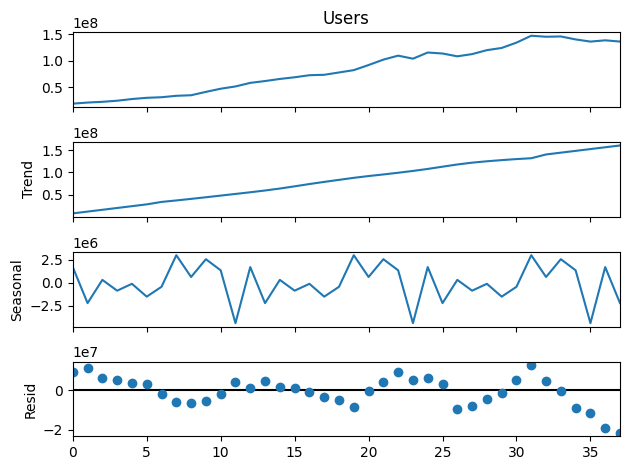

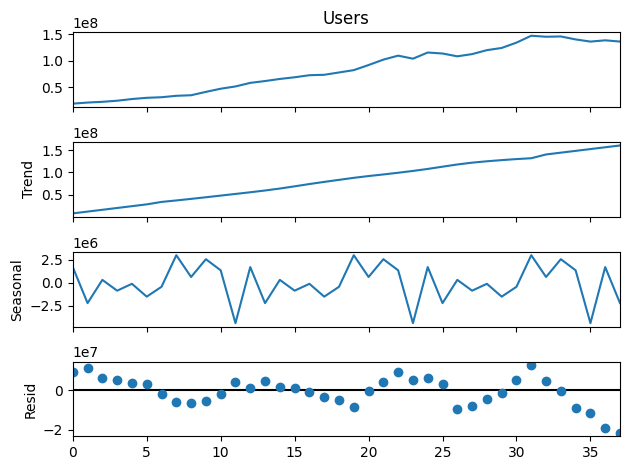

In [12]:
seasonal_decompose(df['Users'], period=12, model='additive', extrapolate_trend='freq').plot()

We next assume a multiplicative form, with $Level = Trend * Seasonal component * Error$.  Multiplicative models make a lot of sense when changes depend on the current level, such as when we observe stock price movements.

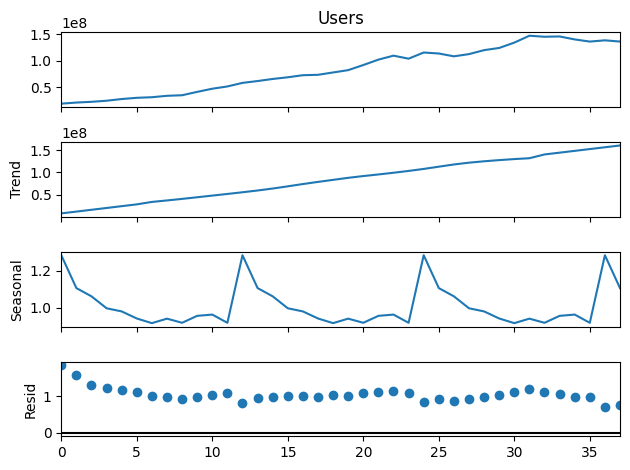

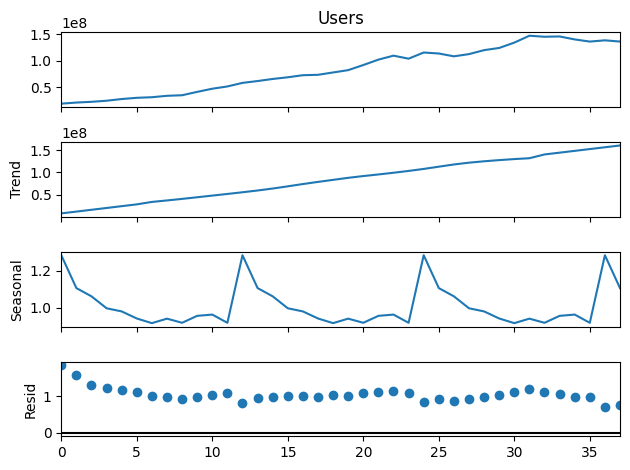

In [13]:
seasonal_decompose(df['Users'], period=12, model='multiplicative', extrapolate_trend='freq').plot()

## 2. ETS models ("Error, Trend, Seasonal")

Next we will use an ETS model to predict number of people in the future. 

The ETS model is fit using the `.fit()` function.

In [14]:
model = ETSModel(df['Users'],
                 error='add',
                 trend='add',damped_trend=False,
                 seasonal='add',seasonal_periods=12)
res = model.fit()

Let's predict the next 9 yerars and 7 months using this model, (9*12+7)=115 months. Here we can forecast the number of Tumblr's users by December 2022.

In [15]:
forecast = res.forecast(115)

In [16]:
print(forecast)

38     1.400354e+08
39     1.421316e+08
40     1.443898e+08
41     1.463995e+08
42     1.508819e+08
           ...     
148    5.383999e+08
149    5.404096e+08
150    5.448919e+08
151    5.500556e+08
152    5.513492e+08
Name: simulation, Length: 115, dtype: float64


Let's be a bit more systematic, by:
- specifying the prediction range
- adding confidence intervals to our prediction
- plotting the prediction (and the confidence intervals)

Starting by defining the range over which we will forecast:

In [17]:
start = df['Date'].iloc[-1].date()+relativedelta(months=1)
end = start+relativedelta(months=114)
forecast_range = pd.date_range(start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d'),freq='MS')
print(forecast_range)

DatetimeIndex(['2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01',
               '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
               '2014-02-01', '2014-03-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=115, freq='MS')


We also want to have confidence intervals around our prediction. While these are not given by default, `statsmodels` allows us to run simulations of our model, which we can use to derive confidence intervals manually.

In [18]:
forecast = res.forecast(len(forecast_range))
sim_results = res.simulate(nsimulations=len(forecast_range),repetitions=100,anchor='end') # Run 100 simulations, starting at the end of the observed data
upper_ci = sim_results.quantile(q=0.9,axis='columns').tolist() # Find the 90% quantile as the upper bound for our confidence interval
lower_ci = sim_results.quantile(q=0.1,axis='columns').tolist() # Find the 10% quantile as the lower bound for our confidence interval
prediction = forecast.tolist() # Also store the actual prediction

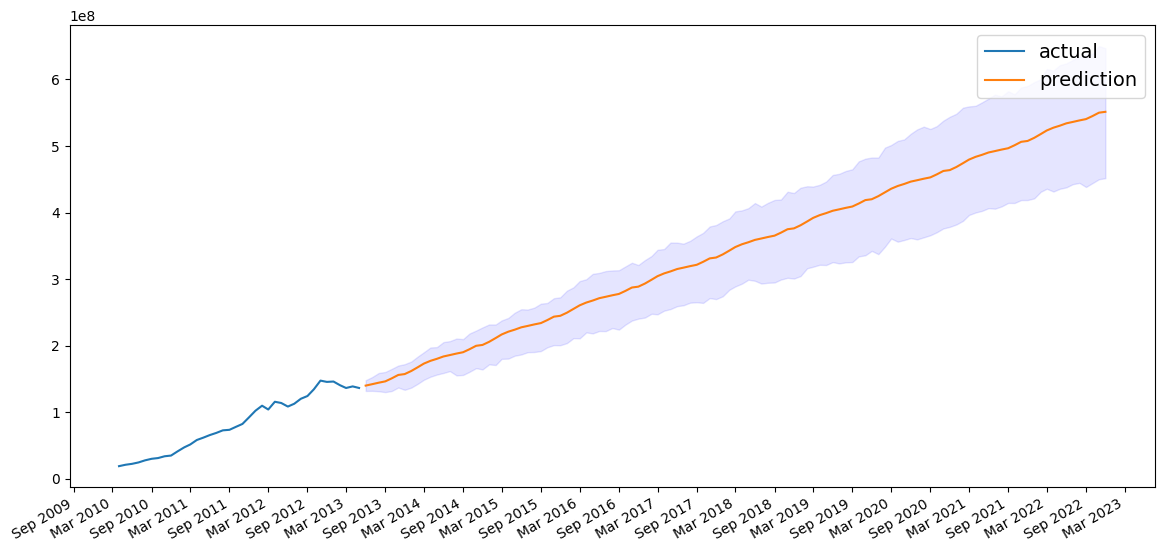

In [19]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['Date'],df['Users'], label='actual')
ax.plot(forecast_range,prediction, label='prediction')
ax.fill_between(forecast_range, lower_ci, upper_ci, color='b', alpha=.1)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.legend(prop={'size': 14})
plt.show()

## 3. Evaluating a time series forecast

In [20]:
df_train = df.iloc[:-8]
df_val = df.iloc[-8:]

Next, we compute a model, then predict for as many months as we have in our validation set:

In [21]:
res = ETSModel(df_train['Users'],
                    error='add',
                    trend='add',damped_trend=False,
                    seasonal='add',seasonal_periods=6).fit()
actual = df_val['Users'].tolist()
prediction = res.forecast(len(df_val)).tolist()

We compute the prediction error. Here, we use the mean absolute percentage error.

In [22]:
mean_absolute_percentage_error(actual,prediction)

0.06968205237748978

Finally, we also compute the Root Mean Squared Error (RMSE).

In [23]:
# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(actual, prediction)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 10792199.69290719


## 4. Going further with TBATS

TBATS stands for "Trigonometric sesonality, Box-Cox Transformation, ARIMA errors, Trend, Sesonal components". In principle, TBATS will try to fit a b unch of different models and see which one performs best - all automatically. Of course, this can be extremely powerful - but it comes at the cost of high computational requirements. The graph below from a [Medium blog post](https://medium.com/analytics-vidhya/time-series-forecasting-using-tbats-model-ce8c429442a9) roughly explains the different options considered.

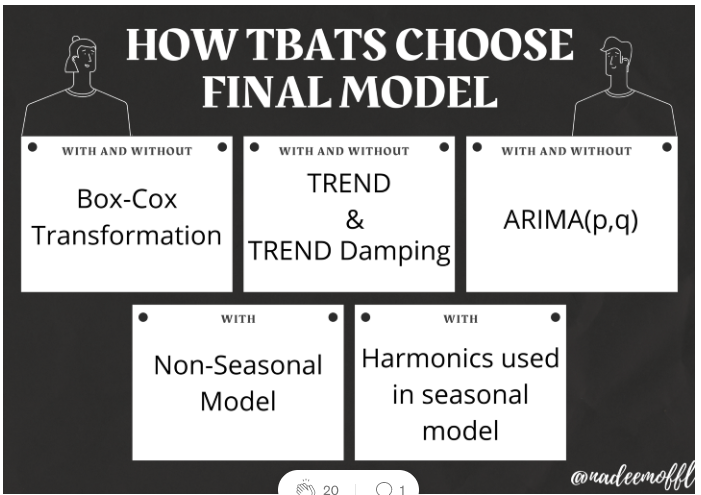

Similarly to the ETS Model, we have to specify the seasonality (though, as a tuple, since we can add multiple seasonalities (!)). Different from ETS, and more in line with other machine learning models, we first create the model, then fit it on the data.

In [24]:
# Create estimator
model = TBATS(seasonal_periods=(12,3))

# Fit model
res = model.fit(df['Users'])

# Summarize fitted model
print(res.summary())

Use Box-Cox: True
Use trend: True
Use damped trend: True
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.325291
Smoothing (Alpha): 1.133905
Trend (Beta): -0.063287
Damping Parameter (Phi): 0.956549
Seasonal Parameters (Gamma): []
AR coefficients []
MA coefficients []
Seed vector [658.51137066  39.34238105]

AIC 1292.780788


As we did with the ETS models, we forecast the number of monthly Tumblr's users by December 2022.

In [25]:
res.forecast(steps=115)

array([1.38160624e+08, 1.40376432e+08, 1.42518281e+08, 1.44587595e+08,
       1.46585877e+08, 1.48514689e+08, 1.50375648e+08, 1.52170410e+08,
       1.53900659e+08, 1.55568104e+08, 1.57174462e+08, 1.58721461e+08,
       1.60210824e+08, 1.61644269e+08, 1.63023505e+08, 1.64350221e+08,
       1.65626089e+08, 1.66852758e+08, 1.68031849e+08, 1.69164956e+08,
       1.70253643e+08, 1.71299440e+08, 1.72303845e+08, 1.73268318e+08,
       1.74194287e+08, 1.75083141e+08, 1.75936233e+08, 1.76754877e+08,
       1.77540352e+08, 1.78293898e+08, 1.79016719e+08, 1.79709981e+08,
       1.80374813e+08, 1.81012308e+08, 1.81623525e+08, 1.82209486e+08,
       1.82771179e+08, 1.83309558e+08, 1.83825544e+08, 1.84320027e+08,
       1.84793863e+08, 1.85247879e+08, 1.85682872e+08, 1.86099608e+08,
       1.86498827e+08, 1.86881240e+08, 1.87247532e+08, 1.87598361e+08,
       1.87934361e+08, 1.88256141e+08, 1.88564288e+08, 1.88859364e+08,
       1.89141910e+08, 1.89412446e+08, 1.89671471e+08, 1.89919465e+08,
      

We also want to have confidence intervals, as before. Note that using the 10% and 90% quantiles as before, corresponds to a confidence level of 80%.

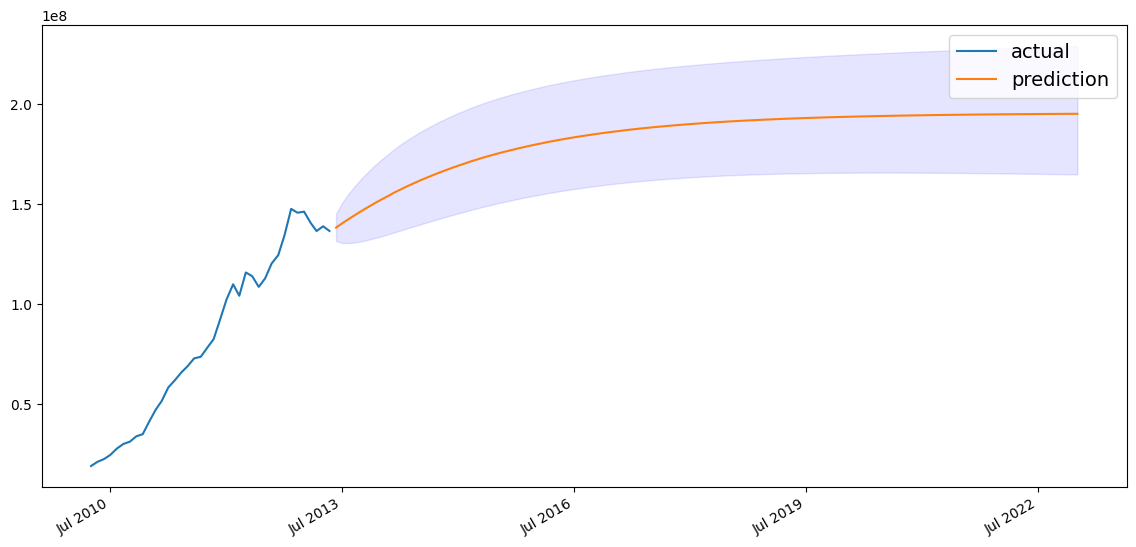

In [26]:
start = df['Date'].iloc[-1].date()+relativedelta(months=1)
end = start+relativedelta(months=115)
forecast_range = pd.date_range(start.strftime('%Y-%m-%d'),end.strftime('%Y-%m-%d'),freq='MS')

forecast, ci = res.forecast(steps=len(forecast_range), confidence_level=0.8)
prediction = forecast.tolist()
upper_ci = ci['upper_bound'].tolist()
lower_ci = ci['lower_bound'].tolist()

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['Date'],df['Users'], label='actual')
ax.plot(forecast_range,prediction, label='prediction')
ax.fill_between(forecast_range, lower_ci, upper_ci, color='b', alpha=.1)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=36))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.legend(prop={'size': 14})
plt.show()

## 5. Evaluating a time series forecast

In [27]:
# Splitting the data into training and validation sets
df_train = df.iloc[:-8]
df_val = df.iloc[-8:]

Next, we compute a model, then predict for as many months as we have in our validation set:

In [28]:
# Creating estimator
model = TBATS(seasonal_periods=(12, 3))

# Fitting model using training data
res = model.fit(df_train['Users'])

actual = df_val['Users'].tolist()
prediction = res.forecast(len(df_val)).tolist()

Finally, we compute the prediction error i.e. mean absolute percentage error.

In [29]:
# Calculate the Mean Absolute Percentage Error (MAPE)
mape_val = mean_absolute_percentage_error(actual, prediction)
print("MAPE:", mape_val)

MAPE: 0.11370744864487672


Finally, we also compute the Root Mean Squared Error (RMSE).

In [30]:
# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(actual, prediction)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 20003807.15690168


# Question 5 Identify online data sources that could help you improve upon one or more of the estimates used. Using Python, for one or more of the identified data sources, create a pipeline to (i) collect data, (ii) clean the data, and (iii) engineer relevant features. You are free to use APIs, BeautifulSoup/Requests, Selenium, or more advanced tools. However, it is essential that there be a significant web scraping component (e.g., navigating to a page and downloading a pre-made dataset will not be enough. Similar, while the use of APIs is encouraged, this should not be the only way to access data). Be reasonable in the number of sources you collect data from – start with one source, and if you have time remaining add further sources that bring a high degree of information per effort.

In [31]:
def extract_twitter_data(url):
    #starting new browser
    driver = webdriver.Chrome() # Use driver = webdriver.Chrome(“Path to executable”) if Selenium is unable to identify the Chrome driver executable
    driver.get(url)
    
    time.sleep(3) # Sleep for 3 seconds
    #accepting cookies
    driver.find_element(By.XPATH,'//*[@id="onetrust-accept-btn-handler"]').click()
    
    #using beautiful soup to scrape chart data of monthly users
    # Parse the HTML content
    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Find the div containing the chart data
    chart_div = soup.find("div", {"data-chart-vars-name": "options"})

    # Extract the data attribute value
    chart_data = chart_div.get("data-chart-vars")
    
    # Convert the data attribute value (JSON string) to a dictionary
    chart_data_dict = json.loads(chart_data)

    # Extracting the categories (quarters)
    categories = chart_data_dict["xAxis"]["categories"]

    # Extracting the data points (number of monthly active users per quarter)
    data_points = chart_data_dict["series"][0]["data"]

    # Create a DataFrame
    df = pd.DataFrame({'Quarter': categories, 'Monthly Active Users (millions)': [point['y'] for point in data_points]})
    
    # Extract the year from the 'Quarters' column
    df['Year'] = df['Quarter'].apply(lambda x: int("20" + x.split("'")[1]))
    
    #removing all irrelavant years from df(sale of tumblr happened Q2 2013 so only previous to that is relevant)
    df =  df.iloc[:13]
    
    return df

In [32]:
twitter_USA_users = extract_twitter_data("https://www.statista.com/statistics/274564/monthly-active-twitter-users-in-the-united-states/")

In [33]:
twitter_USA_users

,Quarter,Monthly Active Users (millions),Year
0,Q1 '10,10,2010
1,Q2 '10,12,2010
2,Q3 '10,14,2010
3,Q4 '10,15,2010
4,Q1 '11,19,2011
5,Q2 '11,23,2011
6,Q3 '11,27,2011
7,Q4 '11,30,2011
8,Q1 '12,34,2012
9,Q2 '12,37,2012


In [34]:
twitter_ROW_users = extract_twitter_data("https://www.statista.com/statistics/282087/number-of-monthly-active-twitter-users/")

In [35]:
twitter_ROW_users

,Quarter,Monthly Active Users (millions),Year
0,Q1 '10,30.0,2010
1,Q2 '10,40.0,2010
2,Q3 '10,49.0,2010
3,Q4 '10,54.0,2010
4,Q1 '11,68.0,2011
5,Q2 '11,85.0,2011
6,Q3 '11,101.0,2011
7,Q4 '11,117.0,2011
8,Q1 '12,138.0,2012
9,Q2 '12,151.0,2012


In [36]:
def extract_twitter_revenue(url):
    #starting new browser
    driver = webdriver.Chrome() # Use driver = webdriver.Chrome(“Path to executable”) if Selenium is unable to identify the Chrome driver executable
    driver.get(url)
    
    time.sleep(3) # Sleep for 3 seconds
    #using beautiful soup to scrape chart data of monthly users
    # Parse the HTML content
    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Find the table
    table = soup.find('table')

    # Extract table headers
    headers = [th.text.strip() for th in table.find_all('th')]

    # Extract table rows
    data = []
    for tr in table.find_all('tr'):
        row = [td.text.strip() for td in tr.find_all('td')]
        if row:
            data.append(row)

    # Create a DataFrame
    df = pd.DataFrame(data, columns=headers)
    
    # Extract the year from the fiscal year column
    df['Fiscal Year End'] = pd.to_datetime(df['Fiscal Year End'])
    df['Year'] = df['Fiscal Year End'].dt.year
    
    #removing all irrelavant years from df(sale of tumblr happened Q2 2013 so only previous to that is relevant)
    df =  df.iloc[-4:]
        
    #cleaning revenue column
    # Remove 'M' from the Revenue column
    df['Revenue'] = df['Revenue'].str.replace('M', '')

    # Convert the Revenue column to numeric
    df['Revenue'] = pd.to_numeric(df['Revenue'])
    
    #the US is responsible for approximately 50% of the company’s revenue on average based on referenced source
    #therefore revenue can be split into ROW and US by halving
    df['Revenue ROW (millions)'] = df['Revenue']/2
    df['Revenue US (millions)'] = df['Revenue']/2
    
    #removing irrelevant columns
    df = df[['Revenue ROW (millions)','Revenue US (millions)','Year']]
    
    return df

In [37]:
twitter_revenue = extract_twitter_revenue('https://stockanalysis.com/stocks/twtr/revenue/')

In [38]:
twitter_revenue

,Revenue ROW (millions),Revenue US (millions),Year
8,332.445,332.445,2013
9,158.465,158.465,2012
10,53.155,53.155,2011
11,14.140,14.140,2010


In [39]:
#get stock data for yahoo during aquisition of tumblr period
def get_stock_data(api_key,ticker_symbol,date_start,date_end):
    # Make API request to get historical stock data
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker_symbol}&apikey={api_key}&outputsize=full'
    response = requests.get(url)
    data = response.json()

    if 'Time Series (Daily)' in data:
        daily_data = data['Time Series (Daily)']
        df = pd.DataFrame(daily_data).T
        df.index = pd.to_datetime(df.index)
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        df.sort_index(inplace=True)
        df = df.loc[date_start : date_end]  # Filter data for 2010 to 2015 to see reaction of tumblr purchase
        # converting dates into datetime type
        df.index = pd.to_datetime(df.index)
        # Convert numeric columns to float (if not already)
        numeric_columns = ['open', 'high', 'low', 'close', 'volume']
        df[numeric_columns] = df[numeric_columns].astype(float)
    else:
        print("Error: Unable to retrieve data from Alpha Vantage.")
        
    return df



In [40]:
# Define your Alpha Vantage API key
api_key = 'H0Z5B4JEH6SUDYOH'
# Define the ticker symbol for Yahoo (YHOO)
ticker_symbol = 'YHOO'
#  define relevant date range
date_start = '2010-01-01'
date_end = '2015-12-31'
#  define relevant date range
date_start_close_look = '2013-01-01'
date_end_close_look = '2013-12-30'
#  define relevant date range
date_start_closest_look = '2013-05-01'
date_end_closest_look = '2013-05-31'

#running function to collect data for 5 year period
df = get_stock_data(api_key,ticker_symbol,date_start,date_end)

#runnining function to take a clooser look around may 20th 2013, the day tumblr purchase was announced
df_close_look = get_stock_data(api_key,ticker_symbol,date_start_close_look,date_end_close_look)

#runnining function to take a clooser look around may 20th 2013, the day tumblr purchase was announced
df_closest_look = get_stock_data(api_key,ticker_symbol,date_start_closest_look,date_end_closest_look)

In [41]:
df.head()

,open,high,low,close,volume
2010-01-04,16.94,17.20,16.880,17.10,16587400.0
2010-01-05,17.22,17.23,17.000,17.23,11718100.0
2010-01-06,17.17,17.30,17.070,17.17,16422000.0
2010-01-07,16.81,16.90,16.570,16.70,31816300.0
2010-01-08,16.68,16.76,16.615,16.70,15470000.0


In [42]:
df_close_look.head()

,open,high,low,close,volume
2013-01-02,20.20,20.317,20.01,20.08,20463100.0
2013-01-03,20.05,20.100,19.72,19.78,19504400.0
2013-01-04,19.76,19.950,19.72,19.86,12489600.0
2013-01-07,19.56,19.580,19.28,19.40,23864500.0
2013-01-08,19.32,19.680,19.30,19.66,16931700.0


In [43]:
df_closest_look.head()

,open,high,low,close,volume
2013-05-01,24.67,24.72,24.26,24.30,11075000.0
2013-05-02,24.34,24.97,24.18,24.97,10651000.0
2013-05-03,25.13,25.25,24.99,25.07,11513900.0
2013-05-06,25.05,25.34,24.92,25.17,11990500.0
2013-05-07,26.01,26.79,25.55,26.07,25883100.0


# Question 6 For each dataset that you scrape, generate a lexicon: a lexicon is a table containing the names of the features of the dataset in the first column, the descriptions of the features in the second column, and the units of the features in the third column.

In [162]:
# Lexicon for Twitter USA users dataset
lexicon_twitter_usa = pd.DataFrame({
    'Feature': ['Quarter', 'Monthly Active Users (millions)', 'Year'],
    'Description': ['Quarter in which data was recorded', 'Number of monthly active users (in millions)', 'Year corresponding to the quarter'],
    'Unit': ['Financial Quarters', 'Millions of People', 'Years']
})

print("Lexicon for Twitter USA Users Dataset:")
lexicon_twitter_usa

Lexicon for Twitter USA Users Dataset:


,Feature,Description,Unit
0,Quarter,Quarter in which data was recorded,Financial Quarters
1,Monthly Active Users (millions),Number of monthly active users (in millions),Millions of People
2,Year,Year corresponding to the quarter,Years


In [163]:
lexicon_twitter_row = pd.DataFrame({
    'Feature': ['Quarter', 'Monthly Active Users (millions)', 'Year'],
    'Description': ['Quarter in which data was recorded', 'Number of monthly active users (in millions)', 'Year corresponding to the quarter'],
    'Unit': ['Financial Quarters', 'Millions of People', 'Years']
})

print("\nLexicon for Twitter ROW Users Dataset:")
lexicon_twitter_row


Lexicon for Twitter ROW Users Dataset:


,Feature,Description,Unit
0,Quarter,Quarter in which data was recorded,Financial Quarters
1,Monthly Active Users (millions),Number of monthly active users (in millions),Millions of People
2,Year,Year corresponding to the quarter,Years


In [164]:
# Lexicon for Twitter revenue dataset
lexicon_twitter_revenue = pd.DataFrame({
    'Feature': ['Revenue ROW (millions)','Revenue US (millions)', 'Year'],
    'Description': ['Twitter revenue for the fiscal year for rest of world (in millions)','Twitter revenue for the fiscal year for US (in millions)', 'Year corresponding to the fiscal year end'],
    'Unit': ['Millions of Dollars', 'Millions of Dollars','Years']
})

print("\nLexicon for Twitter Revenue Dataset:")
lexicon_twitter_revenue


Lexicon for Twitter Revenue Dataset:


,Feature,Description,Unit
0,Revenue ROW (millions),Twitter revenue for the fiscal year for rest o...,Millions of Dollars
1,Revenue US (millions),Twitter revenue for the fiscal year for US (in...,Millions of Dollars
2,Year,Year corresponding to the fiscal year end,Years


In [44]:
#creating a lexicon for dataset
features = ['Open', 'High', 'Low', 'Close', 'Volume']
descriptions = [
    'The opening price of the stock on that day',
    'The highest price of the stock on that day',
    'The lowest price of the stock on that day',
    'The closing price of the stock on that day',
    'The trading volume of the stock on that day'
]
units = ['USD', 'USD', 'USD', 'USD', 'Shares']

# Create a DataFrame for the lexicon
lexicon_df = pd.DataFrame({
    'Feature': features,
    'Description': descriptions,
    'Units': units
})

# Display the lexicon
print('Lexicon for Tumblr stock data')
lexicon_df

Lexicon for Tumblr stock data


,Feature,Description,Units
0,Open,The opening price of the stock on that day,USD
1,High,The highest price of the stock on that day,USD
2,Low,The lowest price of the stock on that day,USD
3,Close,The closing price of the stock on that day,USD
4,Volume,The trading volume of the stock on that day,Shares


# Question 7 Using Python, produce summary statistics and visualizations of the key features in your datasets. Discuss how each dataset can help you improve the valuation model.

In [45]:
# Summary Statistics for Twitter USA Users Dataset
summary_twitter_usa = twitter_USA_users.describe()
print("Summary Statistics for Twitter USA Users Dataset:")
print(summary_twitter_usa)

# Summary Statistics for Twitter ROW Users Dataset
summary_twitter_row = twitter_ROW_users.describe()
print("\n\nSummary Statistics for Twitter ROW Users Dataset:")
print(summary_twitter_row)

# Summary Statistics for Twitter Revenue Dataset
summary_twitter_revenue = twitter_revenue.describe()
print("\n\nSummary Statistics for Twitter Revenue Dataset:")
print(summary_twitter_revenue)

Summary Statistics for Twitter USA Users Dataset:
       Monthly Active Users (millions)         Year
count                        13.000000    13.000000
mean                         27.230769  2011.153846
std                          12.904481     0.987096
min                          10.000000  2010.000000
25%                          15.000000  2010.000000
50%                          27.000000  2011.000000
75%                          37.000000  2012.000000
max                          48.000000  2013.000000


Summary Statistics for Twitter ROW Users Dataset:
       Monthly Active Users (millions)         Year
count                        13.000000    13.000000
mean                        106.846154  2011.153846
std                          58.253535     0.987096
min                          30.000000  2010.000000
25%                          54.000000  2010.000000
50%                         101.000000  2011.000000
75%                         151.000000  2012.000000
max           

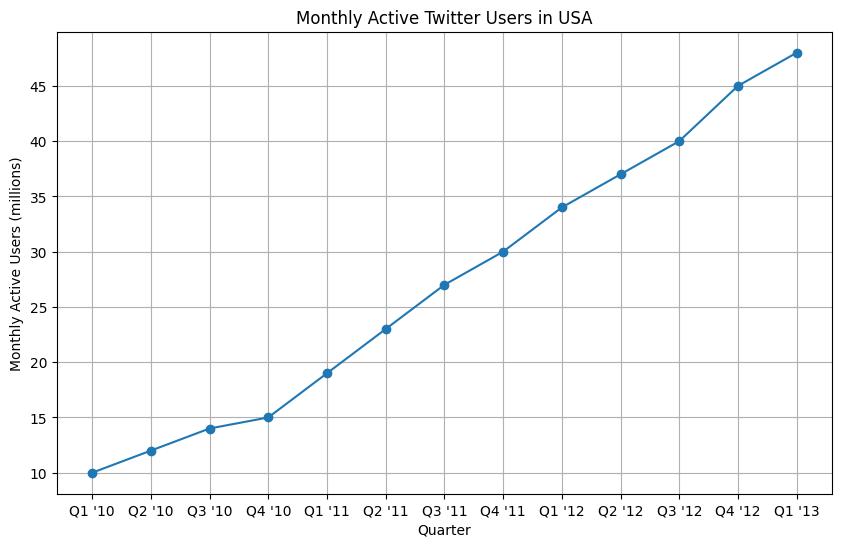

In [46]:
# Visualization for Twitter USA Users Dataset
plt.figure(figsize=(10, 6))
plt.plot(twitter_USA_users['Quarter'], twitter_USA_users['Monthly Active Users (millions)'], marker='o')
plt.title('Monthly Active Twitter Users in USA')
plt.xlabel('Quarter')
plt.ylabel('Monthly Active Users (millions)')
plt.grid(True)
plt.show()

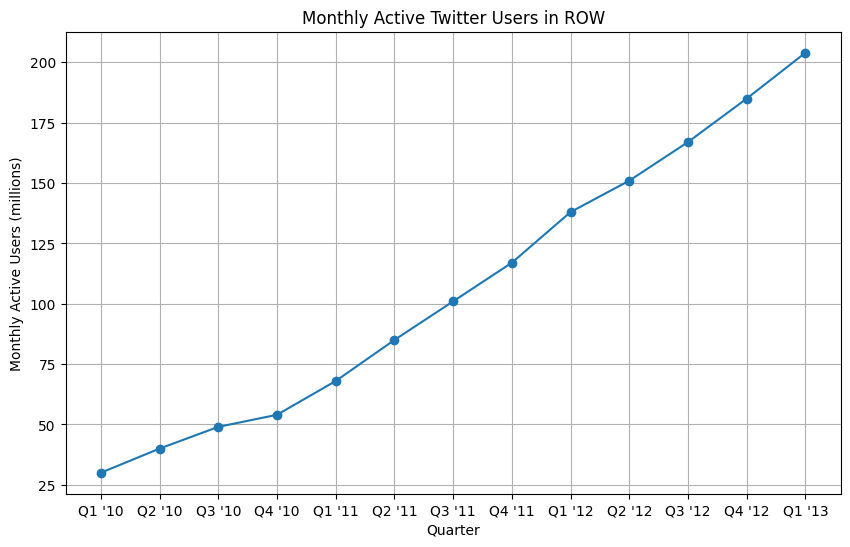

In [47]:
# Visualization for Twitter ROW Users Dataset
plt.figure(figsize=(10, 6))
plt.plot(twitter_ROW_users['Quarter'], twitter_ROW_users['Monthly Active Users (millions)'], marker='o')
plt.title('Monthly Active Twitter Users in ROW')
plt.xlabel('Quarter')
plt.ylabel('Monthly Active Users (millions)')
plt.grid(True)
plt.show()

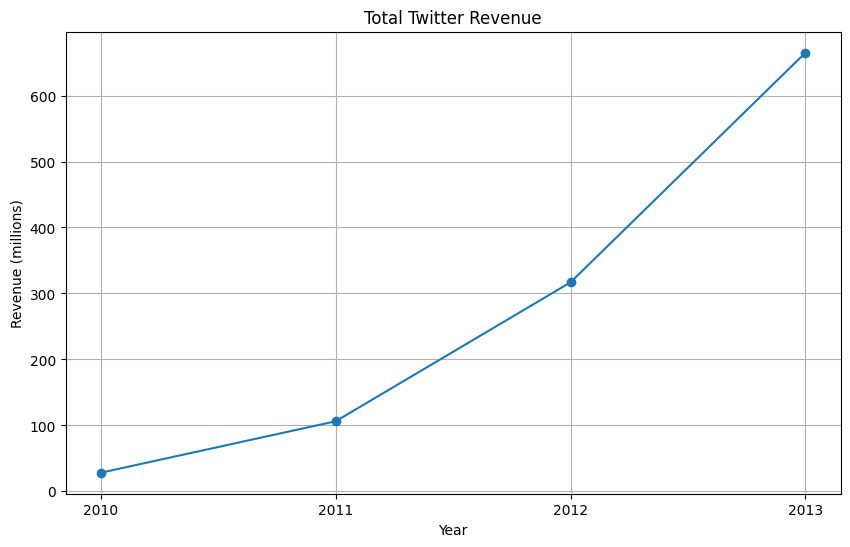

In [48]:
# Visualization for Twitter Revenue Dataset
plt.figure(figsize=(10, 6))
plt.plot(twitter_revenue['Year'], twitter_revenue['Revenue ROW (millions)']*2, marker='o')
plt.title('Total Twitter Revenue')
plt.xlabel('Year')
plt.xticks(twitter_revenue['Year'])
plt.ylabel('Revenue (millions)')
plt.grid(True)
plt.show()

In [49]:
# Summary Statistics
summary_stats = df.describe()
print(summary_stats)

              open         high          low        close        volume
count  1510.000000  1510.000000  1510.000000  1510.000000  1.510000e+03
mean     25.582275    25.876558    25.268594    25.568433  2.110084e+07
std      11.322620    11.439745    11.182374    11.307311  1.424818e+07
min      11.300000    11.800000    11.090000    11.090000  3.470658e+06
25%      15.722500    15.860000    15.540000    15.700000  1.313508e+07
50%      19.560000    19.715000    19.405000    19.610000  1.717089e+07
75%      35.647500    35.982500    35.047500    35.572500  2.449752e+07
max      52.280000    52.620000    51.642000    52.370000  2.336873e+08


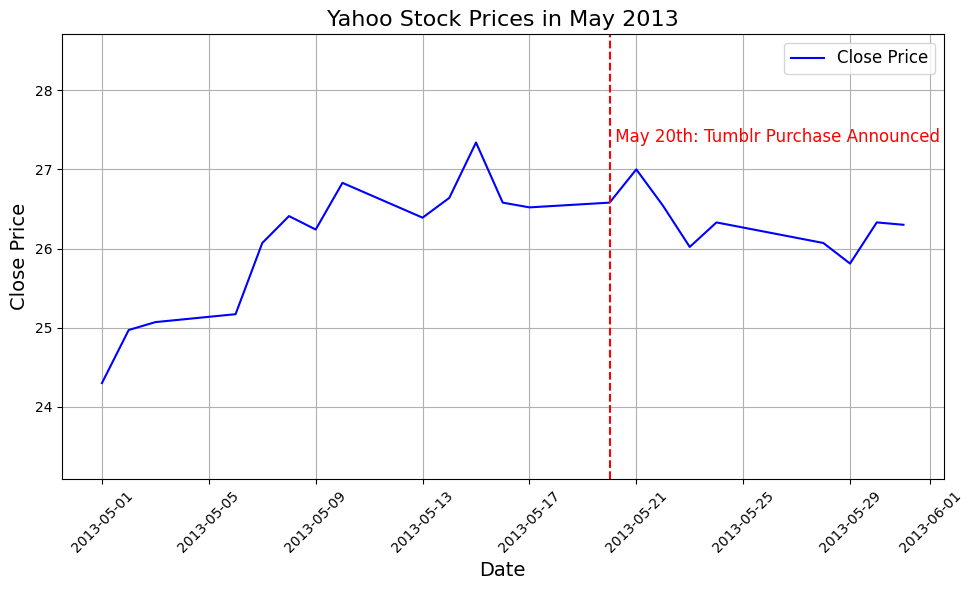

In [50]:
#closest look trend analysis
# Plot the closing price trend
plt.figure(figsize=(10, 6))
plt.plot(df_closest_look.index, df_closest_look['close'], color='blue', label='Close Price')
plt.title('Yahoo Stock Prices in May 2013', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(6))  # Adjust the number of ticks on the y-axis
plt.legend(fontsize=12)
plt.grid(True)

# Convert '2013-05-20' to a datetime object
import datetime
event_date = datetime.datetime(2013, 5, 20)

# Add a vertical line on May 20th
plt.axvline(x=event_date, color='red', linestyle='--')

# Annotate the line with the note
plt.text(event_date, df_closest_look['close'].max(), ' May 20th: Tumblr Purchase Announced', rotation=0, fontsize=12, color='red')


# Adjust y-axis limits
plt.ylim(df_closest_look['close'].min() * 0.95, df_closest_look['close'].max() * 1.05)

plt.tight_layout()
plt.show()

In [ ]:
#close look trend analysis
# Plot the closing price trend
plt.figure(figsize=(10, 6))
plt.plot(df_close_look.index, df_close_look['close'], color='blue', label='Close Price')
plt.title('Yahoo Stock Prices in 2013', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(6))  # Adjust the number of ticks on the y-axis
plt.legend(fontsize=12)
plt.grid(True)

# Convert '2013-05-20' to a datetime object
import datetime
event_date = datetime.datetime(2013, 5, 20)

# Add a vertical line on May 20th
plt.axvline(x=event_date, color='red', linestyle='--')

# Annotate the line with the note
plt.text(event_date, df_closest_look['close'].max() * 0.8, ' May 20th: Tumblr Purchase Announced', rotation=0, fontsize=12, color='red')


# Adjust y-axis limits
plt.ylim(df_close_look['close'].min() * 0.95, df_close_look['close'].max() * 1.05)


plt.tight_layout()
plt.show()

In [51]:
#creating a weekly average data frame
weekly_data = df.resample('W').mean()

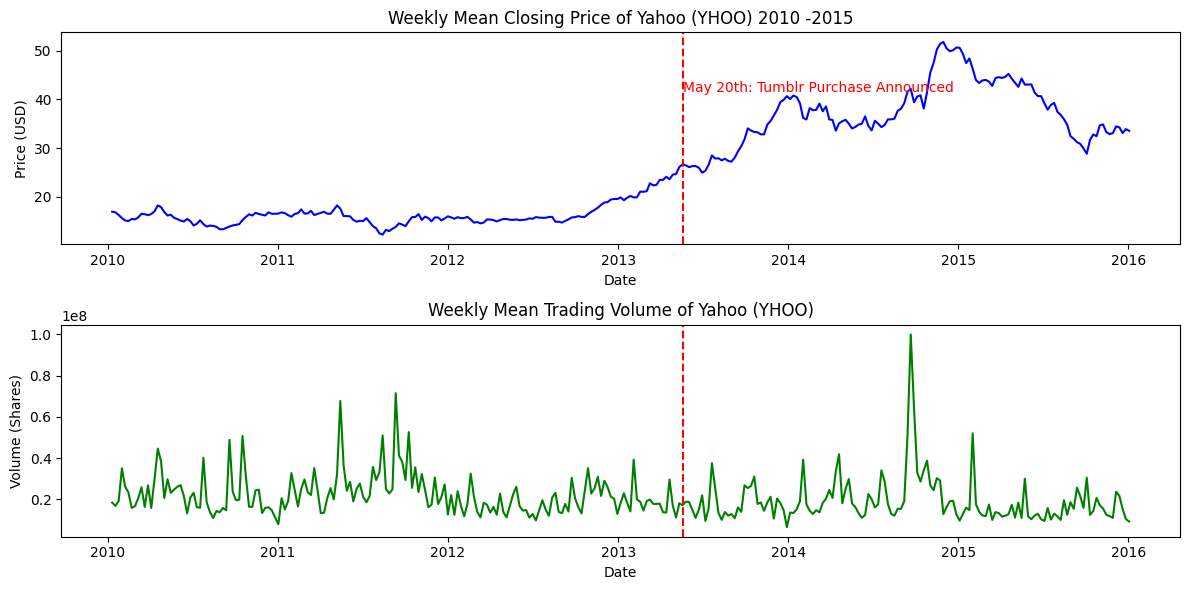

In [52]:
#plotting for enire dataset 2010 to 2015
plt.figure(figsize=(12, 6))

# Plotting the mean closing price
plt.subplot(2, 1, 1)
plt.plot(weekly_data.index, weekly_data['close'], color='blue')
plt.title('Weekly Mean Closing Price of Yahoo (YHOO) 2010 -2015')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

# Add a vertical line on May 20th to the first subplot
event_date = datetime.datetime(2013, 5, 20)
plt.axvline(x=event_date, color='red', linestyle='--')
plt.text(event_date, weekly_data['close'].max()*0.8, 'May 20th: Tumblr Purchase Announced', rotation=0, fontsize=10, color='red')

# Plotting the mean trading volume
plt.subplot(2, 1, 2)
plt.plot(weekly_data.index, weekly_data['volume'], color='green')
plt.title('Weekly Mean Trading Volume of Yahoo (YHOO)')
plt.xlabel('Date')
plt.ylabel('Volume (Shares)')

# Add a vertical line on May 20th to the second subplot
plt.axvline(x=event_date, color='red', linestyle='--')

plt.tight_layout()
plt.show()
